In [160]:

import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random 
from collections import namedtuple, deque 

##Importing the model (function approximator for Q-table)

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import mps
import gym
import numpy as np
import matplotlib.pyplot as plt

In [161]:
import gym
from gym import spaces

import random
import scipy
import numpy as np
import pandas as pd

import stable_baselines3
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN

In [162]:

from scipy.stats import truncnorm

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def get_date_seq(start_date_arr, num_of_weeks_arr): #start_date index 2, num_of_weeks index 3
    date_seq_arr = np.empty(shape=(len(start_date_arr),), dtype='object')
    for i in range(len(date_seq_arr)):
        date_seq_arr[i] = list(range(int(start_date_arr[i]), int(start_date_arr[i]) + int(num_of_weeks_arr[i])*7, 7))
        # if 7 in  date_seq_arr[i]:
        #     print("date seq:", date_seq_arr[i])
        #     print("start date: ", start_date_arr[i])
    return date_seq_arr


def full_obs(_cap_dem_chosen_req, number_of_actions):
    _obs_min_arr = np.full((288+number_of_actions-1, ), 0)
    for i in range(len(_cap_dem_chosen_req)):
        _obs_min_arr[i+int((number_of_actions-1)/2)] = min(_cap_dem_chosen_req[i])
    return _obs_min_arr

In [163]:
def one_hot_encode_airport(airport, num_airports):
    encoding = np.zeros(num_airports)
    encoding[airport] = 1
    return encoding

# Example usage
num_airports = 3
airport1 = 0
airport2 = 1
airport3 = 2

encoded_airport1 = one_hot_encode_airport(airport1, num_airports)
encoded_airport2 = one_hot_encode_airport(airport2, num_airports)
encoded_airport3 = one_hot_encode_airport(airport3, num_airports)

print(encoded_airport1)
print(encoded_airport2)
print(encoded_airport3)

[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]


In [164]:
def generate_info_arv(requests):
    ts_arv = np.empty(shape=(len(requests),), dtype='object')
    start_date_arv = np.empty(shape=(len(requests),), dtype='object')
    #date_seq_arv = np.empty(shape=(len(requests),), dtype='object')
    for i in range(len(requests)):
        ts_arv[i] = requests[i][1] + requests[i][7]/5
        if ts_arv[i] > 287:
            # print("exceed:",ts_arv[i])
            ts_arv[i] = ts_arv[i] - 287
            start_date_arv[i] = requests[i][2] + 1
        else:
            start_date_arv[i] = requests[i][2]

        if start_date_arv[i] == 7:
            start_date_arv[i] = 0
            # print("request: ", requests[i])
    date_seq_arv = get_date_seq(start_date_arv, requests[:, 3])
    return ts_arv, start_date_arv, date_seq_arv

In [165]:
def generate_scenario(number_of_requests, num_airports, cap_dict):
    
    #number_of_requests = 15000
    ts_72 = get_truncated_normal(mean=72, sd=12, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_72 = np.round(ts_72)

    ts_216 = get_truncated_normal(mean=216, sd=12, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_216 = np.round(ts_216)

    ts_dep = np.concatenate((ts_72, ts_216))
    ts_dep = ts_dep.astype(int)

    #Generate start date:

    start_date_dep = np.random.randint(low = 0, high=7, size=number_of_requests) #146 because period is 182 days and we consider series which span at least 5 weeks (+35 days)

    #Generate number of weeks:

    _max_day = np.full(number_of_requests, 6)

    _remaining_days = _max_day - start_date_dep

    _max_num_of_weeks = _remaining_days // 7
    # print(_max_num_of_weeks + 1)

    num_of_weeks =  _max_num_of_weeks + 1

    #Generate index for requests:

    index = np.array(list(range(number_of_requests)))

    #Generate origin (0 and 1 are two considered origin airports, 2 represent other airports, encoded in one-hot vector):

    #num_airports = 3
    origin_airport = np.empty(shape=(number_of_requests,), dtype='object')
    destination_airport = np.empty(shape=(number_of_requests,), dtype='object')
    for i in range(number_of_requests):
        _org_airport = one_hot_encode_airport(random.randint(0,2), num_airports)
        _org_airport_list = _org_airport.tolist()
        origin_airport[i] = _org_airport_list
        #Generate destination (the destination will be different with the origin):
        _dest_airport = _org_airport.copy()
        while np.array_equal(_dest_airport, _org_airport):
            np.random.shuffle(_dest_airport)
        _dest_airport_list = _dest_airport.tolist()
        destination_airport[i] = _dest_airport_list

    #Generate flying time (assume between airport 0 and 1 is 2 hour, 0 to 2 and 1 to 2 is arbitrary):

    fly_time = np.empty(shape=(number_of_requests,), dtype='object')
    for i in range (number_of_requests):
        if origin_airport[i] == list([1.0, 0.0, 0.0]) and destination_airport[i] == list([0.0, 1.0, 0.0]):
            fly_time[i] = 120
        elif origin_airport[i] == list([1.0, 0.0, 0.0]) and destination_airport[i] == list([0.0, 0.0, 1.0]):
            fly_time[i] = random.choice([60, 120, 180])
        elif origin_airport[i] == list([0.0, 1.0, 0.0]) and destination_airport[i] == list([1.0, 0.0, 0.0]):
            fly_time[i] = 120
        elif origin_airport[i] == list([0.0, 1.0, 0.0]) and destination_airport[i] == list([0.0, 0.0, 1.0]):
            fly_time[i] = random.choice([60, 120, 180])
        elif origin_airport[i] == list([0.0, 0.0, 1.0]) and destination_airport[i] == list([1.0, 0.0, 0.0]):
            fly_time[i] = random.choice([60, 120, 180])
        elif origin_airport[i] == list([0.0, 0.0, 1.0]) and destination_airport[i] == list([0.0, 1.0, 0.0]):
            fly_time[i] = random.choice([60, 120, 180])

    #Get date sequence (date seq is actually a list):

    date_seq_dep = get_date_seq(start_date_dep, num_of_weeks)

    #Generate status cap:

    status_cap_dep = np.full((number_of_requests,), 0)
    status_cap_arv = np.full((number_of_requests,), 0)
    

    requests = np.stack((index, ts_dep, start_date_dep, num_of_weeks, date_seq_dep, origin_airport, destination_airport, fly_time, status_cap_dep), axis=1)

    #Generate full info for the arv side:

    ts_arv, start_date_arv, date_seq_arv = generate_info_arv(requests)
    # for d in date_seq_arv:
        # print("date:",d)

    #pseudo_belong_dep = np.full((number_of_requests,), 0)
    #pseudo_belong_arv = np.full((number_of_requests,), 0)
    
    # Define requests_full as dtype object
    # requests_full = np.stack((index, ts_dep, start_date_dep, num_of_weeks, date_seq_dep, origin_airport, destination_airport, fly_time, status_cap_dep, ts_arv, start_date_arv, date_seq_arv, status_cap_arv), axis=1)
    num_entries = len(index)  # Given that 'index' is defined using np.array(list(range(number_of_requests)))
    # Create an empty array of the desired shape with dtype=object
    requests_full = np.empty((num_entries, 13), dtype=object)
    # Fill the array
    data = [index, ts_dep, start_date_dep, num_of_weeks, date_seq_dep, origin_airport, destination_airport, fly_time, status_cap_dep, ts_arv, start_date_arv, date_seq_arv, status_cap_arv]
    for i, column_data in enumerate(data):
        requests_full[:, i] = column_data

    # airport_req_dict: A dictionary where each key corresponds to a specific airport's requirements. 
    # The key format is 'req_i', where i is the index of the airport. 
    # The value for each key is a numpy array, with each row representing a request and the columns containing different attributes of that request.
    airport_req_dict, _belong_airport_dict = get_airport_req_dict(requests_full, num_airports)

    pot_dem_dict = get_initial_pot_dem_per_airport(airport_req_dict, num_airports)

    cap_dem_dict = get_cap_dem_dict(num_airports, cap_dict, pot_dem_dict)
    # print(requests_full)

    return requests_full, airport_req_dict, _belong_airport_dict, pot_dem_dict, cap_dem_dict

#Generate capacity:

cap_arr = np.full((288, 7), 20)
cap_dict  = {}
cap_dict['req_0'] = cap_arr
cap_dict['req_1'] = cap_arr
cap_dict['req_2'] = cap_arr
# print(cap_arr)

#Create final_sched:
generate_scenario(15000, 3, cap_dict)

    


(array([[0, 75, 1, ..., 1, list([1]), 0],
        [1, 59, 5, ..., 5, list([5]), 0],
        [2, 61, 4, ..., 4, list([4]), 0],
        ...,
        [14997, 212, 1, ..., 1, list([1]), 0],
        [14998, 212, 3, ..., 3, list([3]), 0],
        [14999, 232, 1, ..., 1, list([1]), 0]], dtype=object),
 {'req_0': array([[2, 61, 4, ..., 0, 1, 0],
         [4, 67, 1, ..., 0, 0, 1],
         [5, 67, 6, ..., 0, 1, 0],
         ...,
         [14996, 228, 5, ..., 0, 0, 1],
         [14997, 212, 1, ..., 0, 0, 1],
         [14998, 212, 3, ..., 0, 0, 1]], dtype=object),
  'req_1': array([[0, 75, 1, ..., 0, 1, 0],
         [1, 59, 5, ..., 0, 1, 0],
         [3, 79, 4, ..., 0, 1, 0],
         ...,
         [14994, 227, 0, ..., 0, 1, 0],
         [14996, 228, 5, ..., 0, 1, 0],
         [14999, 232, 1, ..., 0, 1, 0]], dtype=object),
  'req_2': array([[0, 75, 1, ..., 0, 0, 1],
         [1, 59, 5, ..., 0, 0, 1],
         [2, 61, 4, ..., 0, 0, 1],
         ...,
         [14997, 212, 1, ..., 0, 1, 0],
        

In [166]:
def get_violate_id_set(airport_req_dict, num_airports):
    violate_set = [] #(1: id, 2: airport, 3: dep, 4: arv)
    for i in range(num_airports):
        mask = ((airport_req_dict['req_{}'.format(i)][:, 8] + airport_req_dict['req_{}'.format(i)][:, 12]) >= 1)
        _id_violate_per_airport = airport_req_dict['req_{}'.format(i)][mask, :][:,0]
        violate_set.append(_id_violate_per_airport)
    violate_set = np.concatenate(violate_set, axis=0)
    violate_set = np.unique(violate_set)
    return violate_set

def get_violate_id_set_req_full(requests_full):
    mask = ((requests_full[:, 8] + requests_full[:, 12]) >= 1)
    violate_set_req_full = requests_full[mask, :][:,0]
    return violate_set_req_full

def get_req(violate_set, requests_full):
    # if not violate_set:
    #     raise ValueError("The provided violate_set is empty!")
    _violate_index = random.choice(violate_set)
    chosen_req = requests_full[requests_full[:,0] == _violate_index]
    return chosen_req

def flatten_cap_dem_dict(cap_dem_dict, num_airports):
    cap_dem_dict_flat = {}
    for i in range(num_airports):
        cap_dem_dict_flat['req_{}'.format(i)] = cap_dem_dict['req_{}'.format(i)].flatten()
    return cap_dem_dict_flat

def get_airport_req_dict(requests_full, num_airports):
    airport_req_dict = {}
    _belong_airport_dict = {}
    for i in range(num_airports):
        airport_req_dict['req_{}'.format(i)] = np.empty((0, 15)) #This one depends on the number of elements of a final request
        _belong_airport_dict['req_{}'.format(i)] = np.full(num_airports, 0.0, dtype=float)
        _belong_airport_dict['req_{}'.format(i)][i] = float(1.0)
        _belong_airport_dict['req_{}'.format(i)] = _belong_airport_dict['req_{}'.format(i)].tolist()
        
    for i in range(len(requests_full)):
        _found_dep = 0
        _found_arv = 0
        for k in range(num_airports):
            #_found_dep = 0
            #_found_arv = 0
            if requests_full[i][5] == _belong_airport_dict['req_{}'.format(k)]:
                _dep_req = np.append(requests_full[i], 1)
                _dep_req = np.append(_dep_req, 0)
                airport_req_dict['req_{}'.format(k)] = np.vstack((airport_req_dict['req_{}'.format(k)], _dep_req))
                _found_dep = 1
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 1)
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 0)
                #break
            if requests_full[i][6] == _belong_airport_dict['req_{}'.format(k)]:
                _arv_req = np.append(requests_full[i], 0)
                _arv_req = np.append(_arv_req, 1)
                airport_req_dict['req_{}'.format(k)] = np.vstack((airport_req_dict['req_{}'.format(k)], _arv_req))
                _found_arv = 1
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 0)
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 1)
                #break
            if _found_dep + _found_arv == 2:
                break
        if _found_dep + _found_arv != 2:
            print("Cannot found both dep and arv at req {}".format(i))
            
    return airport_req_dict, _belong_airport_dict
def generate_deterministic_capacity_dict(num_airports, cap_per_airport_arr): #This function is for a period of 182 days and 288 slots/ day
    cap_dict = {}
    for i in range(num_airports):
        cap_dict['req_{}'.format(i)] = np.full((288, 7), cap_per_airport_arr[i])
    return cap_dict

def get_initial_pot_dem_per_airport(airport_req_dict, num_airports): #Replace req_df to req_df_update to update pot_dem_df #To be replaced with final_sched
    pot_dem_dict = {}
    #TODO: increase speed
    #13 dep 14 arv, 1 dep ts, 9 arv ts
    for i in range(num_airports):
        pot_dem_dict['req_{}'.format(i)] = np.full((288, 7), 0)
        for k in range(len(airport_req_dict['req_{}'.format(i)])):
            _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][13]) + int(airport_req_dict['req_{}'.format(i)][k][9]) * int(airport_req_dict['req_{}'.format(i)][k][14])
            _date_seq = airport_req_dict['req_{}'.format(i)][k][4] * int(airport_req_dict['req_{}'.format(i)][k][13]) + airport_req_dict['req_{}'.format(i)][k][11] * int(airport_req_dict['req_{}'.format(i)][k][14])
            # print("4",airport_req_dict['req_{}'.format(i)][k][4])
            # print("11",airport_req_dict['req_{}'.format(i)][k][11])
            # print(_time_slot)
            # print(_date_seq)
            pot_dem_dict['req_{}'.format(i)][_time_slot, _date_seq] += 1
    return pot_dem_dict

def get_cap_dem_dict(num_airports, cap_dict, pot_dem_dict):
    cap_dem_dict = {}
    for i in range(num_airports):
        # print(pot_dem_dict)
        # print()
        cap_dem_dict['req_{}'.format(i)] = cap_dict['req_{}'.format(i)] - pot_dem_dict['req_{}'.format(i)]
    return cap_dem_dict

def update_status_capacity(airport_req_dict, num_airports, cap_dem_dict, requests_full):
    #Them cot cap_status o init:
    for i in range(num_airports):
        for k in range(len(airport_req_dict['req_{}'.format(i)])):
            _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][13]) + int(airport_req_dict['req_{}'.format(i)][k][9]) * int(airport_req_dict['req_{}'.format(i)][k][14])
            _date_seq = airport_req_dict['req_{}'.format(i)][k][4] * int(airport_req_dict['req_{}'.format(i)][k][13]) + airport_req_dict['req_{}'.format(i)][k][11] * int(airport_req_dict['req_{}'.format(i)][k][14])
            if all(x >= 0 for x in cap_dem_dict['req_{}'.format(i)][_time_slot, _date_seq]):
                # print(airport_req_dict['req_{}'.format(i)][k][4])
                #print(self.cap_dem_arr[_time_slot, _date_seq])
                airport_req_dict['req_{}'.format(i)][k][8] = 0
                airport_req_dict['req_{}'.format(i)][k][12] = 0
            else:
                if airport_req_dict['req_{}'.format(i)][k][13] == 1:
                    airport_req_dict['req_{}'.format(i)][k][8] = 1
                    _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                    requests_full[_indices, 8] = 1
                else:
                    airport_req_dict['req_{}'.format(i)][k][12] = 1
                    _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                    requests_full[_indices, 12] = 1



In [173]:
class TwoAirportSchedEnv(gym.Env):
    def __init__(self, number_of_actions, number_of_requests, num_airports, cap_per_airport_arr):
        
        super(TwoAirportSchedEnv, self).__init__()
        self.number_of_actions = int(number_of_actions)
        self.number_of_requests = number_of_requests
        self.num_airports = num_airports
        self.cap_per_airport_arr = cap_per_airport_arr
        self.cap_dict = generate_deterministic_capacity_dict(self.num_airports, self.cap_per_airport_arr)
        _exceed_cap = 0         
        while _exceed_cap == 0:
            self.requests_full, self.airport_req_dict, self._belong_airport_dict, self.pot_dem_dict, self.cap_dem_dict = generate_scenario(number_of_requests = self.number_of_requests, num_airports = self.num_airports, cap_dict = self.cap_dict)
            self.cap_dem_dict_flat = flatten_cap_dem_dict(self.cap_dem_dict, self.num_airports)
            for i in range(num_airports):
                _exceed_cap = _exceed_cap + (min(self.cap_dem_dict_flat['req_{}'.format(i)]))        
        self.action_space = spaces.Discrete(self.number_of_actions)
        self.agents = self.initialize_agents()
        #self.update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        self.violate_set = self.get_violate_id_set(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        self.num_step = 0
        self.get_req(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        self.dep_time_slot = self.chosen_req[1]
        self.original_requests = self.requests_full

    def initialize_agents(self):
        # Create a dictionary of agents where key is the airport id and value is the agent object
        agent_dict = {}
        for airport_id in range(self.num_airports):  # assuming you have self.num_airports in TwoAirportSchedEnv
            agent = AirportAgent(airport_id, self.num_airports, self.number_of_actions)
            agent_dict[airport_id] = agent
        return agent_dict
    
    def get_agent(self, airport_type):
        # Check for airport type
        if airport_type == "departure":
            airport_index = self.chosen_req[5].index(1.0)
        elif airport_type == "arrival":
            airport_index = self.chosen_req[6].index(1.0)
        else:
            raise ValueError(f"Invalid airport_type: {airport_type}. Expected 'departure' or 'arrival'.")

        agent = self.agents.get(airport_index)
        return agent
    
    def action_mapping(self, action, number_of_actions):
        mid_point = (number_of_actions - 1) // 2
        return action - mid_point
    
    #Randomly choose a violating request to solve
    def get_req(self, airport_req_dict, num_airports, cap_dem_dict, requests_full):

        if not self.violate_set:
          self.violate_set = self.get_violate_id_set(airport_req_dict, num_airports, cap_dem_dict, requests_full)
          if not self.violate_set:
            self.chosen_req = None 
            return self.chosen_req 

        airport_num, airport_index, request_violate_index = random.choice(self.violate_set)
        valid = self.check_status_capacity(airport_req_dict, cap_dem_dict, requests_full, airport_num, airport_index, request_violate_index)

        while not valid:

          if not self.violate_set:
            self.violate_set = self.get_violate_id_set(airport_req_dict, num_airports, cap_dem_dict, requests_full)
            if not self.violate_set:
              self.chosen_req = None 
              return self.chosen_req 

          airport_num, airport_index, request_violate_index = random.choice(self.violate_set)
          valid = self.check_status_capacity(airport_req_dict, cap_dem_dict, requests_full, airport_num, airport_index, request_violate_index)

        self.chosen_req = self.requests_full[self.requests_full[:,0] == request_violate_index][0]

        return self.chosen_req
    
    #need to check arrival time or change the variable to check_outbound(arv) and chec_outbound(dep)
    def check_outbound(self, action):
        dep_time_slot = self.chosen_req[1]
        arv_time_slot = self.chosen_req[9]

        outbound = False

        new_dep_time_slot = dep_time_slot + action
        new_arv_time_slot = arv_time_slot + action

        if (new_dep_time_slot < 0) or (new_dep_time_slot > 287) or (new_arv_time_slot < 0) or (new_arv_time_slot > 287):
            outbound = True

        return outbound
    
    def dep_or_arv(self):
        pass

    def update_dem(self, dep_airport, arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv, date_seq_dep, date_seq_arv):
        # Increment demand for the new time slot for both departure and arrival airports
        self.pot_dem_dict['req_{}'.format(dep_airport)][new_time_slot_dep, date_seq_dep] += 1
        self.pot_dem_dict['req_{}'.format(arv_airport)][new_time_slot_arv, date_seq_arv] += 1

        # Decrease demand for the initial time slot for both departure and arrival airports
        self.pot_dem_dict['req_{}'.format(dep_airport)][time_slot_dep, date_seq_dep] -= 1
        self.pot_dem_dict['req_{}'.format(arv_airport)][time_slot_arv, date_seq_arv] -= 1

    def update_cap_dem(self):
        for airport in range(self.num_airports):
            cap_key = 'req_{}'.format(airport)
            dem_key = 'req_{}'.format(airport)
            if cap_key not in self.cap_dict:
                raise KeyError(f"'{cap_key}' not found in cap_dict. Available keys: {list(self.cap_dict.keys())}")
            self.cap_dem_dict[cap_key] = self.cap_dict[cap_key] - self.pot_dem_dict[dem_key]
    def check_status_capacity(self, airport_req_dict, cap_dem_dict, requests_full, airport_num, airport_index, request_index):

        _time_slot = int(airport_req_dict['req_{}'.format(airport_num)][airport_index][1]) * int(airport_req_dict['req_{}'.format(airport_num)][airport_index][13]) + int(airport_req_dict['req_{}'.format(airport_num)][airport_index][9]) * int(airport_req_dict['req_{}'.format(airport_num)][airport_index][14])
        _date_seq = airport_req_dict['req_{}'.format(airport_num)][airport_index][4] * int(airport_req_dict['req_{}'.format(airport_num)][airport_index][13]) + airport_req_dict['req_{}'.format(airport_num)][airport_index][11] * int(airport_req_dict['req_{}'.format(airport_num)][airport_index][14])

        if (airport_num, airport_index, request_index) in self.violate_set:
            self.violate_set.remove((airport_num, airport_index, request_index))

        if all(x >= 0 for x in cap_dem_dict['req_{}'.format(airport_num)][_time_slot, _date_seq]):

            airport_req_dict['req_{}'.format(airport_num)][airport_index][8] = 0
            airport_req_dict['req_{}'.format(airport_num)][airport_index][12] = 0
            requests_full[request_index, 8] = 0
            requests_full[request_index, 12] = 0

            valid = False
        else:
            if airport_req_dict['req_{}'.format(airport_num)][airport_index][13] == 1:
                airport_req_dict['req_{}'.format(airport_num)][airport_index][8] = 1
                requests_full[request_index, 8] = 1
            else:
                airport_req_dict['req_{}'.format(airport_num)][airport_index][12] = 1
                requests_full[request_index, 12] = 1

            valid = True

        return valid

    def update_status_capacity(self, airport_req_dict, num_airports, cap_dem_dict, requests_full):
    #Them cot cap_status o init:
        not_violate_update = set()
        violate_update = set()
        for i in range(num_airports):
            for k in range(len(airport_req_dict['req_{}'.format(i)])):
                _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][13]) + int(airport_req_dict['req_{}'.format(i)][k][9]) * int(airport_req_dict['req_{}'.format(i)][k][14])
                _date_seq = airport_req_dict['req_{}'.format(i)][k][4] * int(airport_req_dict['req_{}'.format(i)][k][13]) + airport_req_dict['req_{}'.format(i)][k][11] * int(airport_req_dict['req_{}'.format(i)][k][14])
                if all(x >= 0 for x in cap_dem_dict['req_{}'.format(i)][_time_slot, _date_seq]):
                    #print(self.cap_dem_arr[_time_slot, _date_seq])
                    if airport_req_dict['req_{}'.format(i)][k][8] == 1 or airport_req_dict['req_{}'.format(i)][k][12] == 1:
                        not_violate_update.add(airport_req_dict['req_{}'.format(i)][k][0])
                    airport_req_dict['req_{}'.format(i)][k][8] = 0
                    airport_req_dict['req_{}'.format(i)][k][12] = 0
                else:
                    if airport_req_dict['req_{}'.format(i)][k][8] == 0 and airport_req_dict['req_{}'.format(i)][k][12] == 0:
                        violate_update.add(airport_req_dict['req_{}'.format(i)][k][0])
                    if airport_req_dict['req_{}'.format(i)][k][13] == 1:
                        airport_req_dict['req_{}'.format(i)][k][8] = 1
                        _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                        requests_full[_indices, 8] = 1
                    else:
                        airport_req_dict['req_{}'.format(i)][k][12] = 1
                        _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                        requests_full[_indices, 12] = 1

        return not_violate_update, violate_update
    
    def get_violate_id_set(self, airport_req_dict, num_airports, cap_dem_dict, requests_full):
        self.update_status_capacity(airport_req_dict, num_airports, cap_dem_dict, requests_full)
        violate_set = [] #(1: id, 2: airport, 3: dep, 4: arv)
        for i in range(num_airports):
            for k in range(len(airport_req_dict['req_{}'.format(i)])):
                if airport_req_dict['req_{}'.format(i)][k][8] + airport_req_dict['req_{}'.format(i)][k][12] >= 1:
                    violate_set.append((i, k, airport_req_dict['req_{}'.format(i)][k][0]))

        return violate_set
    # Need to validate
    def update_violate_set(curr_violate, not_violate_update, violate_update):
        curr_violate = set(curr_violate)
        for req_index in not_violate_update:
            curr_violate.remove(req_index)
        for req_index in violate_update:
            curr_violate.add(req_index) 
        curr_violate = list(curr_violate)
        return curr_violate 
    
    def take_action(self,state,eps):
        # Step 1: Randomly choose actions
        # action_dep = self.action_space.sample()  # For the departure airport
        # action_arv = self.action_space.sample()  # For the arrival airport
        self.dep_agent = self.get_agent('departure')
        self.arv_agent = self.get_agent('arrival')
        print(state)
        action_dep = self.dep_agent.act(state,eps)
        action_arv = self.arv_agent.act(state,eps)

        #Step 2: Check if actions match
        # matched_action = None
        while action_dep != action_arv:
            return 1

        return action_dep
    
    def when_take_action(self, action):
        # num_actions = self.number_of_actions
        # # Convert the discrete action to your desired action value
        # real_action = self.action_mapping(action, num_actions)        

        _index = self.chosen_req[0]
        time_slot_dep = self.chosen_req[1]
        time_slot_arv = self.chosen_req[9]
        time_slot_arv = int(time_slot_arv)
        _dep_airport = self.chosen_req[5].index(1.0)
        _arv_airport = self.chosen_req[6].index(1.0)
        _date_seq_dep = self.chosen_req[4]
        _date_seq_arv = self.chosen_req[11]
        _start_date_dep = self.chosen_req[2]
        _start_date_arv = self.chosen_req[10]
        _num_weeks = self.chosen_req[3]
        # new_time_slot_dep = time_slot_dep + real_action
        new_time_slot_dep = time_slot_dep + action
        # new_time_slot_arv = time_slot_arv + real_action
        new_time_slot_arv = time_slot_arv + action
        new_time_slot_arv = int(new_time_slot_arv)
        new_date_seq_dep = _date_seq_dep
        new_date_seq_arv = _date_seq_arv

        outbound = self.check_outbound(action)

        if not outbound:
            pass
            
        elif outbound:
            # Adjust the departure time slot as needed
            if new_time_slot_dep < 0:
                new_time_slot_dep = 287  # Move to the last time slot of the previous day
                new_start_date_dep = _start_date_dep - 1
                new_date_seq_dep = get_date_seq(new_start_date_dep, _num_weeks)
            elif new_time_slot_dep > 287:
                new_time_slot_dep = 0  # Move to the first time slot of the next day
                new_start_date_dep = _start_date_dep + 1
                new_date_seq_dep = get_date_seq(new_start_date_dep, _num_weeks)
            # Adjust the departure time slot as needed
            if new_time_slot_arv < 0:
                # Assume that we only move by max one slot for a timeslot change
                new_time_slot_arv = 287  # Move to the last time slot of the previous day
                new_time_slot_arv = int(new_time_slot_arv)
                new_start_date_arv = _start_date_arv - 1
                new_date_seq_arv = get_date_seq(new_start_date_arv, _num_weeks)
            elif new_time_slot_dep > 287:
                # Assume that we only move by max one slot for a timeslot change
                new_time_slot_dep = 0  # Move to the first time slot of the next day
                new_time_slot_arv = int(new_time_slot_arv)
                new_start_date_arv = _start_date_arv + 1
                new_date_seq_arv = get_date_seq(new_start_date_arv, _num_weeks)

        else:
            print('Problem with check outbound!')
            
        # Update the request for both departure and arrival time slots and dates
        self.requests_full[self.requests_full[:, 0] == _index][:, 1] = new_time_slot_dep
        self.requests_full[self.requests_full[:, 0] == _index][:, 9] = new_time_slot_arv
        # self.requests_full[self.requests_full[:, 0] == _index][:, 4] = new_date_seq_dep
        # self.requests_full[self.requests_full[:, 0] == _index][:, 11] = new_date_seq_arv
        _index_matching = np.where(self.requests_full[:, 0] == _index)[0][0]
        self.requests_full[_index_matching, 4] = new_date_seq_dep
        self.requests_full[_index_matching, 11] = new_date_seq_arv

        # Update the airport request dict
        self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 1] = new_time_slot_dep
        self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 9] = new_time_slot_arv
        self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 1] = new_time_slot_dep
        self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 9] = new_time_slot_arv

        # Update demand for the new time slots
        self.update_dem(_dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv, new_date_seq_dep, new_date_seq_arv)
        
        # Update cap_dem 
        self.update_cap_dem()

        # Update status capacity after the cap_dem table is updated
        update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)

    def step(self,state,eps):
        action = self.take_action(state,eps)
        num_actions = self.number_of_actions
        # agent_actions = [agent.action_mapping(action, num_actions) for action, agent in zip(action, self.agents)]
        # Convert the discrete action to your desired action value
        real_action = self.action_mapping(action, num_actions)   
        print("action is: ", real_action)    
        _num_weeks = self.chosen_req[3]
        self.when_take_action(real_action)
        outbound = self.check_outbound(real_action)

        # Reward part:
        if action != 0:
            
            local_reward = 0
            if outbound:
                # local_reward = -1
                local_reward = 0.1*(-abs(action)*0.5*_num_weeks)
            else:
                local_reward = 0.1*(-abs(action)*0.5*_num_weeks) #TODO change if increase number of actions
            
            self.num_step += 1
            done = False
            if self.chosen_req[8] == 0 and self.chosen_req[12] == 0:
                done = True
                obs = np.zeros((580))
                global_reward = 10

            elif self.num_step == self.number_of_requests*5:
                done = True
                obs = np.zeros((580))
                negative_sum = -10
                for value in self.cap_dem_dict.values():
                    # Assuming each value is a numeric value or a numpy array
                    # If it's a numpy array, you can sum all negative values directly using numpy
                    if isinstance(value, np.ndarray):
                        negative_sum -= np.sum(value[value < 0])
                    else:
                        # If it's a single numeric value, just check if it's negative
                        if value < 0:
                            negative_sum -= value
                global_reward = negative_sum

            else:
                global_reward = 0
                obs = self._next_observation(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
                # obs = np.zeros((self.number_of_actions + 1,))

            reward_time_step = -0.5
        

        else:
            reward_time_step = -0.5
            local_reward = 0
            global_reward = 0
            obs = self._next_observation(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
            done = False
            
        total_reward = float(local_reward + global_reward + reward_time_step)
    
        

        self.dep_agent.step(state,action,total_reward,obs,done)
        self.arv_agent.step(state,action,total_reward,obs,done)
        rewards = []
        #for those airport that are not affected
        for id,agent in self.agents.items():

            if id != self.dep_agent.airport_id and id != self.arv_agent.airport_id:
                agent.step(state,action,reward_time_step,obs,done)
                rewards.append(reward_time_step)
            else:
                rewards.append(total_reward)

        
        return obs, rewards, done, {} 
    
    def _next_observation(self, airport_req_dict, num_airports, cap_dem_dict, requests_full):
        self.get_req(airport_req_dict, num_airports, cap_dem_dict, requests_full)
        _ts_dep = self.chosen_req[1]
        _ts_arv = self.chosen_req[9]
        _date_seq_dep = self.chosen_req[4]
        _date_seq_arv = self.chosen_req[11]
        _dep_airport = self.chosen_req[5].index(1.0)
        _arv_airport = self.chosen_req[6].index(1.0)
        cap_dem_arr_dep = self.cap_dem_dict['req_{}'.format(_dep_airport)]
        cap_dem_arr_arv = self.cap_dem_dict['req_{}'.format(_arv_airport)]
        _cap_dem_dep = cap_dem_arr_dep[:, _date_seq_dep].copy()
        _cap_dem_arv = cap_dem_arr_arv[:, _date_seq_arv].copy()

        #no of violated:
        _final_cap_dem_flat_dep = cap_dem_arr_dep.flatten()
        _final_cap_dem_flat_arv = cap_dem_arr_arv.flatten()
        # print("cap length: ",len(cap_dem_arr_dep))
        _final_violate_dep = len(_final_cap_dem_flat_dep[_final_cap_dem_flat_dep < 0])
        _final_violate_arv = len(_final_cap_dem_flat_arv[_final_cap_dem_flat_arv < 0])

        self.obs = np.append(_final_violate_dep, _ts_dep)
        self.obs = np.append(self.obs, _cap_dem_dep)
        self.obs = np.append(self.obs, _final_violate_arv)
        self.obs = np.append(self.obs, _ts_arv)
        self.obs = np.append(self.obs, _cap_dem_arv)
        # print("length of observation: ",len(self.obs))
        # print(self.obs)
        return self.obs

    def reset(self):    
        # # Reset each agent
        # for agent in self.agents.values():
        #     agent.reset()    
            
        generate_scenario(self.number_of_requests, self.num_airports, cap_dict = self.cap_dict)
        _dep_airport = self.chosen_req[5].index(1.0)
        _arv_airport = self.chosen_req[6].index(1.0)
        cap_dem_arr_dep = self.cap_dem_dict['req_{}'.format(_dep_airport)]
        cap_dem_arr_arv = self.cap_dem_dict['req_{}'.format(_arv_airport)]
        
        _cap_dem_flat_dep = cap_dem_arr_dep.flatten()
        _cap_dem_flat_arv = cap_dem_arr_arv.flatten()

        while (min(_cap_dem_flat_dep) >= 0 or min(_cap_dem_flat_arv) >= 0):
            generate_scenario(self.number_of_requests, self.num_airports, cap_dict = self.cap_dict)
            _cap_dem_flat_dep = cap_dem_arr_dep.flatten()
            _cap_dem_flat_arv = cap_dem_arr_arv.flatten()
        
        update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        print('Number of violation for dep: ', len(_cap_dem_flat_dep[_cap_dem_flat_dep < 0]))
        print('Number of violation for arv: ', len(_cap_dem_flat_arv[_cap_dem_flat_arv < 0]))

        self.num_step = 0        
        return self._next_observation(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
    
    # Need to validate
    def eval(self):
        _dep_airport = self.chosen_req[5].index(1.0)
        _arv_airport = self.chosen_req[6].index(1.0)
        _initial_cap_dem_dict = {}
        _initial_pot_dem_dict = get_initial_pot_dem_per_airport(self.airport_req_dict, self.num_airports)
        for airport in range(self.num_airports):
            cap_key = 'req_{}'.format(airport)
            dem_key = 'req_{}'.format(airport)
            _initial_cap_dem_dict[cap_key] = self.cap_dict[cap_key] - _initial_pot_dem_dict[dem_key]

        _initial_cap_dem_dep = self.cap_dem_dict['req_{}'.format(_dep_airport)]
        _initial_cap_dem_flat_dep = _initial_cap_dem_dep.flatten()
        _initial_violate_dep = len(_initial_cap_dem_flat_dep[_initial_cap_dem_flat_dep < 0])
        print('Initial violation of departure is: ', _initial_violate_dep)
        _initial_cap_dem_arv = self.cap_dem_dict['req_{}'.format(_arv_airport)]
        _initial_cap_dem_flat_arv = _initial_cap_dem_arv.flatten()
        _initial_violate_arv = len(_initial_cap_dem_flat_arv[_initial_cap_dem_flat_arv < 0])
        print('Initial violation of arrival is: ', _initial_violate_arv)

        cap_dem_arr_dep = self.cap_dem_dict['req_{}'.format(_dep_airport)]
        cap_dem_arr_arv = self.cap_dem_dict['req_{}'.format(_arv_airport)]
        _final_cap_dem_flat_dep = cap_dem_arr_dep.flatten()
        _final_cap_dem_flat_arv = cap_dem_arr_arv.flatten()
        _final_violate_dep = len(_final_cap_dem_flat_dep[_final_cap_dem_flat_dep < 0])
        _final_violate_arv = len(_final_cap_dem_flat_arv[_final_cap_dem_flat_arv < 0])
        print('Final violation of departure is: ', _final_violate_dep)
        print('Final violation of arrival is: ', _final_violate_arv)

        _total_sched_delay_dep = sum(abs(self.original_requests[:,1] - self.requests_full[:,1])* self.original_requests[:,3])
        print('Total schedule delay of departure is: ', _total_sched_delay_dep)
        _total_sched_delay_arv = sum(abs(self.original_requests[:,9] - self.requests_full[:,9])* self.original_requests[:,3])
        print('Total schedule delay of arrival is: ', _total_sched_delay_arv)

        _max_shift_dep = max(abs(self.original_requests[:,1] - self.requests_full[:,1]))
        print('Max shift of departure: ', _max_shift_dep)
        _max_shift_arv = max(abs(self.original_requests[:,9] - self.requests_full[:,9]))
        print('Max shift of arrival: ', _max_shift_arv)

        _unaccom_req_dep = len(self.requests_full[self.requests_full[:,8] == 1])
        print('Number of unaccommodate departure requests: ', _unaccom_req_dep)
        _unaccom_req_arv = len(self.requests_full[self.requests_full[:,12] == 1])
        print('Number of unaccommodate arrival requests: ', _unaccom_req_arv)

        return _initial_violate_dep, _initial_violate_arv, _final_violate_dep, _final_violate_arv, _total_sched_delay_dep, _total_sched_delay_arv, _max_shift_dep, _max_shift_arv, _unaccom_req_dep, _unaccom_req_arv

In [168]:
# def test_next_observation():
    # Call the _next_observation function for that instance.
env = TwoAirportSchedEnv(number_of_actions=3, number_of_requests=15000, num_airports=3, cap_per_airport_arr= [9,9,9])
#how the observation look like: len of 580 
# obs = env._next_observation()
obs = env._next_observation( env.airport_req_dict, env.num_airports, env.cap_dem_dict, env.requests_full)
# print(obs)



In [169]:
class QNetwork(nn.Module):
    """ Actor (Policy) Model."""
    def __init__(self, state_size,action_size, seed, fc1_unit=64,
                 fc2_unit = 64):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
        """
        super(QNetwork,self).__init__() ## calls __init__ method of nn.Module class
        self.seed = torch.manual_seed(seed)
        self.fc1= nn.Linear(state_size,fc1_unit)
        # print(seed)
        self.fc2 = nn.Linear(fc1_unit,fc2_unit)
        self.fc3 = nn.Linear(fc2_unit,action_size)
        
    def forward(self,x):
        # x = state
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [170]:
BUFFER_SIZE = int(1e5)  #replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class AirportAgent():
    """Interacts with and learns form environment."""
    
    def __init__(self, airport_id, num_airports, number_of_actions):
    # self, state_size, action_size, seed
        """Initialize an Agent object.
        
        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        super(AirportAgent, self).__init__()

        self.airport_id = airport_id
        self.num_airports = num_airports
        self.number_of_actions = number_of_actions
        self.action_space = spaces.Discrete(self.number_of_actions)
        self.rewards = []
        self.state = one_hot_encode_airport(self.airport_id, self.num_airports)
        self.state_size = 580
        self.action_size = 3
        self.seed = random.seed(0)
        
        
        
        #Q- Network
        self.qnetwork_local = QNetwork(self.state_size, self.action_size, seed=0).to(device)
        self.qnetwork_target = QNetwork(self.state_size, self.action_size,seed=0).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        
        # Replay memory 
        self.memory = ReplayBuffer(self.action_size, BUFFER_SIZE,BATCH_SIZE,seed=0)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def set(self):
        return self.state
    
    def action_mapping(self, action, number_of_actions):
        mid_point = (number_of_actions - 1) // 2
        return action - mid_point
        
    def step(self, state, action, reward, next_step, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get radom subset and learn

            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)
    def act(self, state, eps = 0):
        """Returns action for given state as per current policy
        Params
        =======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    # def learn(self, experiences, gamma):
    #     """Update value parameters using given batch of experience tuples.
    #     Params
    #     =======
    #         experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
    #         gamma (float): discount factor
    #     """
    #     states, actions, rewards, next_states, dones = experiences
    #     ## TODO: compute and minimize the loss
    #     criterion = torch.nn.MSELoss()
    #     # Local model is one which we need to train so it's in training mode
    #     self.qnetwork_local.train()
    #     # Target model is one with which we need to get our target so it's in evaluation mode
    #     # So that when we do a forward pass with target model it does not calculate gradient.
    #     # We will update target model weights with soft_update function
    #     self.qnetwork_target.eval()
    #     #shape of output from the model (batch_size,action_dim) = (64,4)
    #     predicted_targets = self.qnetwork_local(states).gather(1,actions)
    
    #     with torch.no_grad():
    #         labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

    #     # .detach() ->  Returns a new Tensor, detached from the current graph.
    #     labels = rewards + (gamma* labels_next*(1-dones))
        
    #     loss = criterion(predicted_targets,labels).to(device)
    #     self.optimizer.zero_grad()
    #     loss.backward()
    #     self.optimizer.step()

    #     # ------------------- update target network ------------------- #
    #     self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        ## TODO: compute and minimize the loss
        criterion = torch.nn.MSELoss()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()
        #shape of output from the model (batch_size,action_dim) = (64,4)
        predicted_targets = self.qnetwork_local(states).gather(1,actions)

        #################Updates for Double DQN learning###########################
        self.qnetwork_local.eval()
        with torch.no_grad():
            actions_q_local = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1).long()
            labels_next = self.qnetwork_target(next_states).gather(1,actions_q_local)
        self.qnetwork_local.train()
        ############################################################################

        # .detach() ->  Returns a new Tensor, detached from the current graph.
        labels = rewards + (gamma* labels_next*(1-dones))

        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
            
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
        

In [171]:
class ReplayBuffer:
    """Fixed -size buffe to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory."""
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


Number of violation for dep:  497
Number of violation for arv:  472
[497.  80.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.
   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.
   9.   9.   9.   8.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.
   9.   9.   9.   9.   9.   9.   8.   8.   7.   8.   9.   6.   4.   5.
   7.   4.   6.   1.   6.   3.   1.  -1.  -2.  -4.  -3.  -2.  -9.  -3.
   0.  -6.  -8.   0.  -7.  -7.  -6.  -6.  -6.  -2.  -1.  -1.  -6.  -8.
  -5.  -5.  -3.   0.  -8.  -5.  -2.  -8.   0.  -5.  -2. -11.   0.  -8.
   0.  -4.  -3.   0.   2.  -5.   0.   5.   3.   0.   3.   4.  -1.   1.
   0.   9.   1.   3.   5.   4.   6.   5.   5.   8.   5.   5.   7.   9.
   8.   9.   8.   9.   7.   8.   9.   9.   9.   9.   8.   9.   9.   7.
   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.
   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.
   9.   9.   9.   9.   9.   9.   9.   9.   8.   9.   9.   9.   9.   9.
   8.   9

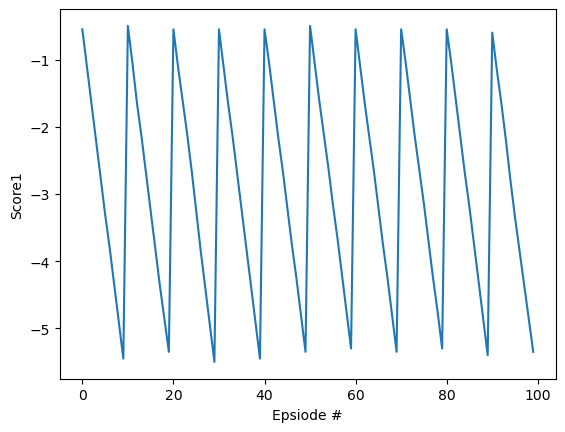

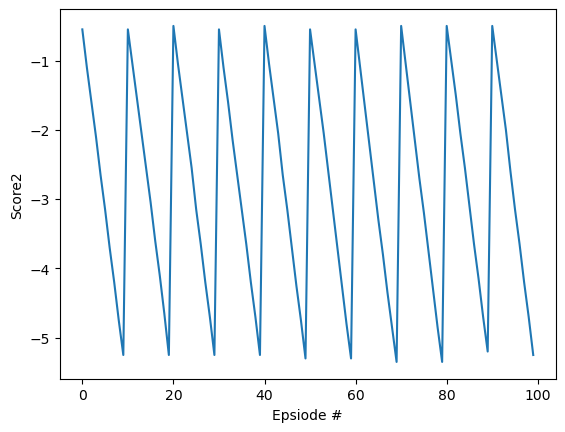

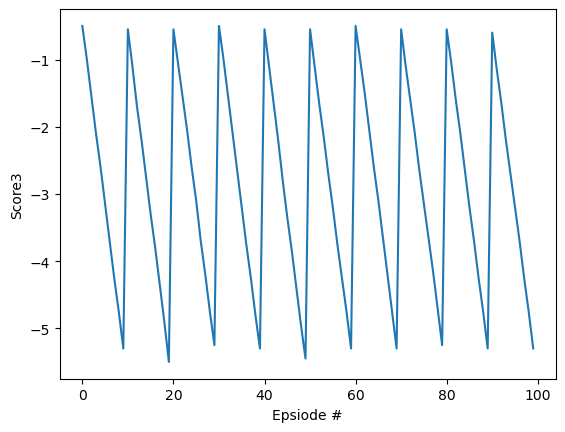

In [174]:

    
# env = gym.make('LunarLander-v2')
env = TwoAirportSchedEnv(number_of_actions=3, number_of_requests=15000, num_airports=3, cap_per_airport_arr= [9,9,9])

def dqn(n_episodes= 10, max_t = 10, eps_start=1.0, eps_end = 0.01,
       eps_decay=0.995):
    """Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon 
        eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon
        
    """
    scores1 = [] # list containing score from each episode
    scores_window1 = deque(maxlen=100) # last 100 scores
    scores2 = [] # list containing score from each episode
    scores_window2 = deque(maxlen=100) # last 100 scores
    scores3 = [] # list containing score from each episode
    scores_window3 = deque(maxlen=100) # last 100 scores
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        # print(state)
        # print(type(state))
        # print(np.asarray(state[0]))
        score1 = 0
        score2 = 0
        score3 = 0
        for t in range(max_t):
            # print(np.asarray(state[0]))
            # print("here")
            # action = agent.act(state,eps) # put this into env.take_action
            
            # print(action)
            # print(env.step(action))obs, total_reward, done, {}
            next_state,rewards,done,_ = env.step(state,eps)
            # print(next_state)
            # agent.step(state,action,reward,next_state,done) #move this into env
            ## above step decides whether we will train(learn) the network
            ## actor (local_qnetwork) or we will fill the replay buffer
            ## if len replay buffer is equal to the batch size then we will
            ## train the network or otherwise we will add experience tuple in our 
            ## replay buffer.
            state = next_state
            print(rewards[0])
            score1 += rewards[0]
            score2 += rewards[1]
            score3 += rewards[2]
            if done:
                break
            scores_window1.append(score1) ## save the most recent score
            scores1.append(score1) ## sae the most recent score
            scores_window2.append(score2) ## save the most recent score
            scores2.append(score2) ## sae the most recent score
            scores_window3.append(score3) ## save the most recent score
            scores3.append(score3) ## sae the most recent score
            eps = max(eps*eps_decay,eps_end)## decrease the epsilon
            print('\rEpisode {}\tAverage Score {:.2f}'.format(i_episode,np.mean(scores_window1)), end="")
            if i_episode %100==0:
                print('\rEpisode {}\tAverage Score {:.2f}'.format(i_episode,np.mean(scores_window1)))
                
            if np.mean(scores_window1)>=100.0:
                print('\nEnvironment solve in {:d} epsiodes!\tAverage score: {:.2f}'.format(i_episode-100,
                                                                                           np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(),'checkpoint.pth')
                break
    return scores1,scores2,scores3

scores1,scores2,scores3= dqn()


#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores1)),scores1)
plt.ylabel('Score1')
plt.xlabel('Epsiode #')
plt.show()

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.plot(np.arange(len(scores2)),scores2)
plt.ylabel('Score2')
plt.xlabel('Epsiode #')
plt.show()

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
plt.plot(np.arange(len(scores3)),scores3)
plt.ylabel('Score3')
plt.xlabel('Epsiode #')
plt.show()


In [ ]:
#load the weights from file to test model
# agent = Agent(state_size=8,action_size=4,seed=0)
# agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# for i in range(3):
#     state = env.reset()
#     img = plt.imshow(env.render(mode='rgb_array'))
#     for j in range(200):
#         action = agent.act(state)
#         img.set_data(env.render(mode='rbg_array'))
#         plt.axix('off')
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
#         state,reward,done,_ = env.step(action)
#         if done:
#             break

# env.close()

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint.pth'